In [5]:
import torch
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms as transforms


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

from torchvision.utils import save_image

import matplotlib.pyplot as plt
import math

In [6]:
import os
from os import listdir

In [7]:
BASE_PATH_DATA = '../data/'

In [8]:
n_epochs = 5
batch_size = 64
lr = 1e-3
b1 = 0.9
b2 = 0.999
img_size = 28
channels = 1

log_interval = 100


z_size = 40

n = 28 * 28

# from running
# EPSILON = np.finfo(tf.float32.as_numpy_dtype).tiny
#EPSILON = 1.1754944e-38
EPSILON = 1e-10

In [9]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")

In [10]:
print("Device")
print(device)

Device
cuda:0


In [11]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        BASE_PATH_DATA + '/mnist/train',
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor()]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        BASE_PATH_DATA + '/mnist/test', 
        train=False, 
        download = True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor()]
        )
    ),
    batch_size=batch_size, shuffle=True
)

In [12]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [13]:
def gumbel_keys(w):
    # sample some gumbels
    uniform = (1.0 - EPSILON) * torch.rand_like(w) + EPSILON
    z = torch.log(-torch.log(uniform))
    w = w + z
    return w


def continuous_topk(w, k, t, separate=False):
    softmax = nn.Softmax(dim = -1)
    khot_list = []
    onehot_approx = torch.zeros_like(w, dtype = torch.float32)
    for i in range(k):
        ### conver the following into pytorch
        #khot_mask = tf.maximum(1.0 - onehot_approx, EPSILON)
        max_mask = 1 - onehot_approx < EPSILON
        khot_mask = 1 - onehot_approx
        khot_mask[max_mask] = EPSILON
        
        w += torch.log(khot_mask)
        #onehot_approx = tf.nn.softmax(w / t, axis=-1)
        onehot_approx = softmax(w/t)
        khot_list.append(onehot_approx)
    if separate:
        return torch.stack(khot_list)
    else:
        return torch.sum(torch.stack(khot_list), dim = 0) 


def sample_subset(w, k, t=0.1):
    '''
    Args:
        w (Tensor): Float Tensor of weights for each element. In gumbel mode
            these are interpreted as log probabilities
        k (int): number of elements in the subset sample
        t (float): temperature of the softmax
    '''
    w = gumbel_keys(w)
    return continuous_topk(w, k, t)

In [14]:
class VAE_Gumbel_MNIST(nn.Module):
    def __init__(self, input_size, hidden_layer_size, z_size, k, t = 0.1):
        super(VAE_Gumbel_MNIST, self).__init__()
        
        self.k = k
        self.t = t
        
        self.weight_creator = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, input_size)
        )
        
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc21 = nn.Linear(hidden_layer_size, z_size)
        self.fc22 = nn.Linear(hidden_layer_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, input_size)

    def encode(self, x):
        w = self.weight_creator(x)
        subset_indices = sample_subset(w, self.k, self.t)
        x = x * subset_indices
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [15]:
def train(model, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [16]:
def test(model, epoch, k):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         '../data/gumbel_on_mnist/k_{}_reconstruction_'.format(k) + 
                           str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [13]:
model = VAE_Gumbel_MNIST(784, 400, 20, k = k).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (b1,b2))

In [14]:
for epoch in range(1, n_epochs + 1):
        train(model, optimizer, epoch)
        #with torch.no_grad():
        #    diag_model.diag.data[torch.abs(diag_model.diag) < 0.05] = 0
        test(model, epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../data/gumbel_on_mnist/k_{}_sample_'.format(k) + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 547.400330
Train Epoch: 1 [6400/60000 (11%)]	Loss: 208.939606
Train Epoch: 1 [12800/60000 (21%)]	Loss: 183.220062
Train Epoch: 1 [19200/60000 (32%)]	Loss: 174.540253
Train Epoch: 1 [25600/60000 (43%)]	Loss: 168.974152
Train Epoch: 1 [32000/60000 (53%)]	Loss: 166.143539
Train Epoch: 1 [38400/60000 (64%)]	Loss: 156.947495
Train Epoch: 1 [44800/60000 (75%)]	Loss: 159.339264
Train Epoch: 1 [51200/60000 (85%)]	Loss: 154.260208
Train Epoch: 1 [57600/60000 (96%)]	Loss: 155.986191
====> Epoch: 1 Average loss: 175.4085
====> Test set loss: 150.1431
Train Epoch: 2 [0/60000 (0%)]	Loss: 152.002121
Train Epoch: 2 [6400/60000 (11%)]	Loss: 141.981140
Train Epoch: 2 [12800/60000 (21%)]	Loss: 147.464172
Train Epoch: 2 [19200/60000 (32%)]	Loss: 143.369217
Train Epoch: 2 [25600/60000 (43%)]	Loss: 154.665802
Train Epoch: 2 [32000/60000 (53%)]	Loss: 150.158340
Train Epoch: 2 [38400/60000 (64%)]	Loss: 140.129517
Train Epoch: 2 [44800/60000 (75%)]	Loss: 150.037109
Train Ep

KeyboardInterrupt: 

In [17]:
for i, (data, _) in enumerate(test_loader):
    data = data.to(device)
    break

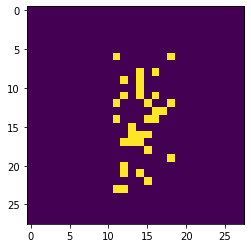

In [20]:
with torch.no_grad():
    w = model.weight_creator(data[3, :].view(-1, 784))
    subset_indices = sample_subset(w, k=50, t=0.1)
plt.imshow(subset_indices.reshape((28, 28)) > 0.01)

Train Epoch: 1 [0/60000 (0%)]	Loss: 549.401611
Train Epoch: 1 [6400/60000 (11%)]	Loss: 200.720215
Train Epoch: 1 [12800/60000 (21%)]	Loss: 205.774826
Train Epoch: 1 [19200/60000 (32%)]	Loss: 186.701508
Train Epoch: 1 [25600/60000 (43%)]	Loss: 193.055817
Train Epoch: 1 [32000/60000 (53%)]	Loss: 197.984131
Train Epoch: 1 [38400/60000 (64%)]	Loss: 179.042389
Train Epoch: 1 [44800/60000 (75%)]	Loss: 182.433334
Train Epoch: 1 [51200/60000 (85%)]	Loss: 183.756561
Train Epoch: 1 [57600/60000 (96%)]	Loss: 184.392181
====> Epoch: 1 Average loss: 199.9500
====> Test set loss: 185.1121
Train Epoch: 2 [0/60000 (0%)]	Loss: 194.596848
Train Epoch: 2 [6400/60000 (11%)]	Loss: 179.105362
Train Epoch: 2 [12800/60000 (21%)]	Loss: 196.009354
Train Epoch: 2 [19200/60000 (32%)]	Loss: 179.727295
Train Epoch: 2 [25600/60000 (43%)]	Loss: 183.429153
Train Epoch: 2 [32000/60000 (53%)]	Loss: 182.986740
Train Epoch: 2 [38400/60000 (64%)]	Loss: 175.261795
Train Epoch: 2 [44800/60000 (75%)]	Loss: 180.290482
Train Ep

Train Epoch: 5 [6400/60000 (11%)]	Loss: 145.841507
Train Epoch: 5 [12800/60000 (21%)]	Loss: 150.234604
Train Epoch: 5 [19200/60000 (32%)]	Loss: 144.747711
Train Epoch: 5 [25600/60000 (43%)]	Loss: 149.950638
Train Epoch: 5 [32000/60000 (53%)]	Loss: 154.203384
Train Epoch: 5 [38400/60000 (64%)]	Loss: 140.329529
Train Epoch: 5 [44800/60000 (75%)]	Loss: 148.329681
Train Epoch: 5 [51200/60000 (85%)]	Loss: 155.659760
Train Epoch: 5 [57600/60000 (96%)]	Loss: 162.580917
====> Epoch: 5 Average loss: 153.2566
====> Test set loss: 153.3160
Train Epoch: 1 [0/60000 (0%)]	Loss: 548.480225
Train Epoch: 1 [6400/60000 (11%)]	Loss: 205.167847
Train Epoch: 1 [12800/60000 (21%)]	Loss: 164.541702
Train Epoch: 1 [19200/60000 (32%)]	Loss: 152.453781
Train Epoch: 1 [25600/60000 (43%)]	Loss: 144.748306
Train Epoch: 1 [32000/60000 (53%)]	Loss: 142.930588
Train Epoch: 1 [38400/60000 (64%)]	Loss: 139.976364
Train Epoch: 1 [44800/60000 (75%)]	Loss: 130.243927
Train Epoch: 1 [51200/60000 (85%)]	Loss: 127.974213
Tra

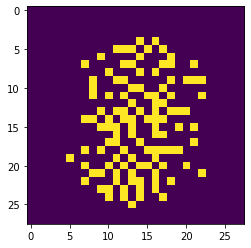

In [21]:
k_all = [10, 25, 50, 250]

for k in k_all:
    model = VAE_Gumbel_MNIST(784, 400, 20, k = k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (b1,b2))
    for epoch in range(1, n_epochs + 1):
        train(model, optimizer, epoch)
        #with torch.no_grad():
        #    diag_model.diag.data[torch.abs(diag_model.diag) < 0.05] = 0
        test(model, epoch, k)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../data/gumbel_on_mnist/k_{}_sample_'.format(k) + str(epoch) + '.png')
    with torch.no_grad():
        w = model.weight_creator(data[0, :].view(-1, 784))
        subset_indices = sample_subset(w, k=k, t=0.1).cpu()
    plt.imshow(subset_indices.reshape((28, 28)) > 0.01)
    plt.imsave('../data/gumbel_on_mnist/k_{}_example_featureselected.png'.format(k), 
               subset_indices.reshape((28, 28)) > 0.01)